# Linear Regression Notebook

This notebook is designed to walk through and complete a full regression analysis from start to end using seaborn, scikitlearn and statsmodels.

There are the followinng requirements of the data that must be completed from the EDA.
1. Null values must be removed
2. All categorical variables must be encoded
3. Problem must have numeric predictors and a numeric response variable i.e. not classification

In [48]:
# general python libraries
import time
import sys
import datetime
import math
import numpy as np

# dataframe and data manipulation library
import pandas as pd

# visualisation and EDA libraries
import matplotlib.pyplot as  plt
import pandas_profiling
import seaborn as sns
import popmon
from popmon import resources
from popmon.config import Report, Settings

# machine learning libraries
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn import metrics
import statsmodels.regression.linear_model as sm

## Data Importing

In [2]:
folder_path = '../data/raw'
train_data = pd.read_csv(f'{folder_path}/train.csv')
test_data = pd.read_csv(f'{folder_path}/test.csv')
sample = pd.read_csv(f'{folder_path}/sample_submission.csv')

## Dataset Summaries and Heads

In [3]:
print("Number of rows in train data:    \t",train_data.shape[0])
print("Number of columns in train data: \t",train_data.shape[1])
print("\nNumber of rows in test data:     \t",test_data.shape[0])
print("Number of columns in test data:  \t",test_data.shape[1])
print("\nNumber of rows in sample data:   \t",sample.shape[0])
print("Number of column in sample data: \t",sample.shape[1])

Number of rows in train data:    	 1460
Number of columns in train data: 	 81

Number of rows in test data:     	 1459
Number of columns in test data:  	 80

Number of rows in sample data:   	 1459
Number of column in sample data: 	 2


In [4]:
# check datatypes of columns
print(train_data.dtypes.value_counts())

# this data should have no object data types
print(train_data.dtypes == 'object')

object     43
int64      35
float64     3
dtype: int64
Id               False
MSSubClass       False
MSZoning          True
LotFrontage      False
LotArea          False
                 ...  
MoSold           False
YrSold           False
SaleType          True
SaleCondition     True
SalePrice        False
Length: 81, dtype: bool


non-numeric column categories based on data from  1460 rows


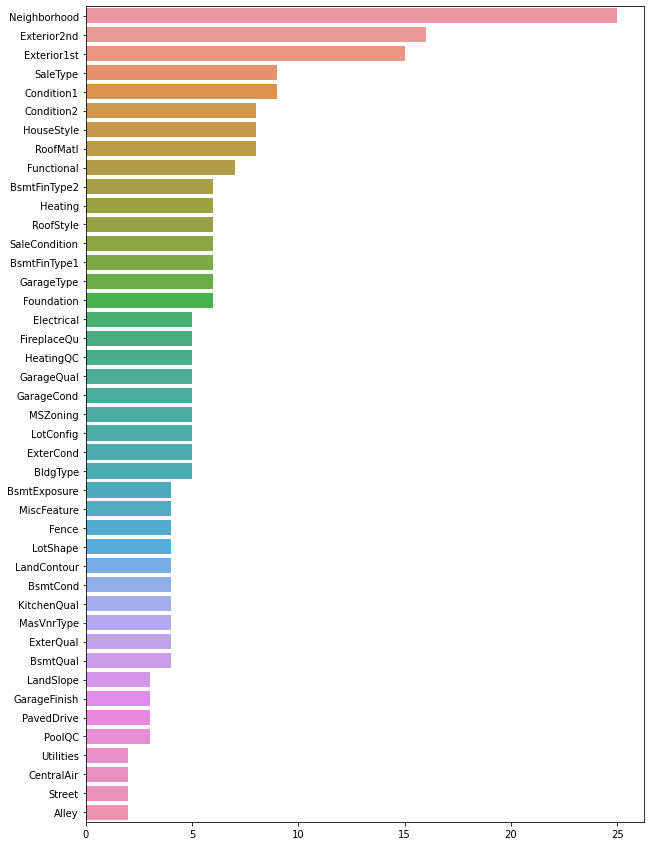

In [5]:
# save names of categorical columns
numeric_cols = train_data.dtypes[train_data.dtypes != "object"].index
cat_cols = train_data.dtypes[train_data.dtypes == "object"].index

# view cardinalitites of categorical columns
print('non-numeric column categories based on data from ', train_data.shape[0],'rows')

cat_name = []
nunique_vals = []
for i in cat_cols:
    cat_name.append(i)
    nunique_vals.append(train_data.loc[:,i].nunique())

cat_counts = pd.Series(data=nunique_vals,index=cat_name).sort_values(ascending = False)

fig = plt.figure(figsize=(10,15))
ax = sns.barplot(y = cat_counts.index, x = cat_counts, orient='h')

In [6]:
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [7]:
test_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [8]:
sample.head()

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977


In [9]:
# checking missing data
total = train_data.isnull().sum().sort_values(ascending = False)
percent = (train_data.isnull().sum()/train_data.isnull().count()*100).sort_values(ascending = False)
missing_train_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_train_data

,Total,Percent
PoolQC,1453,99.520548
MiscFeature,1406,96.301370
Alley,1369,93.767123
Fence,1179,80.753425
FireplaceQu,690,47.260274
...,...,...
ExterQual,0,0.000000
Exterior2nd,0,0.000000
Exterior1st,0,0.000000
RoofMatl,0,0.000000


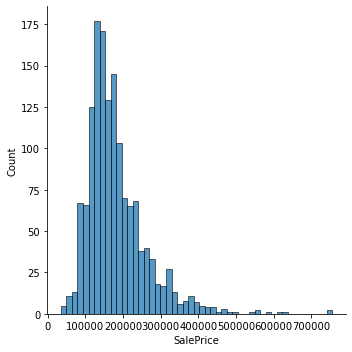

In [13]:
# checking target variable percentage
#sns.countplot(x="failure", data=train_data)
#sns.countplot(x="failure", data=test_data)
#sns.countplot(x="failure", data=sample)

sns.displot(x="SalePrice", data = train_data)

# this is a class imbalance problem

## Linear Regression Fitting

In [38]:
# create a quick and small only numeric dataset
df_num = train_data.loc[:,numeric_cols].dropna().drop('Id',axis = 1)

In [39]:
y = df_num[['SalePrice']]
X = df_num.drop(['SalePrice'],axis = 1)

In [40]:
X.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,548,0,61,0,0,0,0,0,2,2008
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,460,298,0,0,0,0,0,0,5,2007
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,608,0,42,0,0,0,0,0,9,2008
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,642,0,35,272,0,0,0,0,2,2006
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,836,192,84,0,0,0,0,0,12,2008


In [41]:
y.head()

,SalePrice
0,208500
1,181500
2,223500
3,140000
4,250000


In [49]:
model = sm.OLS(y,X)
results = model.fit()

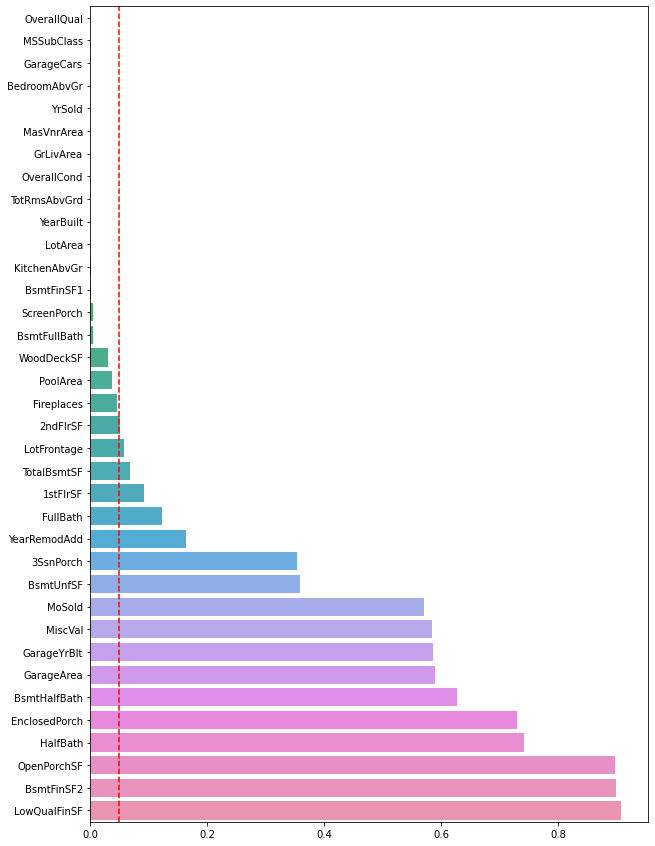

In [98]:
p_values = results.pvalues.sort_values(ascending=True)

fig = plt.figure(figsize=(10,15))
plt.axvline(x=0.05, ls='--', c = 'red')
ax = sns.barplot(y = p_values.index, x = p_values, orient='h')